## 1. Set up

In [1]:
import pandas as pd
import os
import base64
import time
import pickle as p
import numpy as np
import matplotlib.pyplot as plt
import pandas.core.algorithms as algos
from sklearn.model_selection import train_test_split
from sklearn import metrics
from functools import reduce
import datetime
from dateutil.relativedelta import relativedelta
import logging
import matplotlib.style as style
import matplotlib
import matplotlib.lines as mlines
from matplotlib.ticker import FuncFormatter
style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
import gc
gc.collect()

51

## 2. Data Loading & Preprocessing

In [4]:
data_file_path = '../data/'

### 2.1 TPA & Client

In [5]:
# Client & TPA

TPA = pd.read_excel(data_file_path + 'Copy_of_TPA_cash.xlsx',sheet_name='Sheet1')
Client = pd.read_excel(data_file_path + 'Client_info_20191118.xlsx',sheet_name='Sheet1')
# 3 Clients have duplicates records
# Client[Client['Client ID'].isin([1500,7601,2449])]
Client = Client.drop(Client.index[[0,1,497]])


Client = Client.merge(TPA,how='left',left_on='Client ID',right_on='HOST ID')
Client['TPA'] = Client['TPA_x']
Client.loc[Client['TPA_x'].isnull(),'TPA'] = Client.loc[Client['TPA_x'].isnull(),'TPA_y']
Client['TPA'] = Client['TPA'].apply(lambda x: x.upper() if pd.notnull(x) else np.nan)
Client.drop(['TPA_x','TPA_y','HOST ID'],axis=1,inplace = True)

In [6]:
# You might want to delete TPA, uncomment following line
# del TPA

### 2.2 Customer

In [7]:
Customer_old = pd.read_csv(data_file_path + 'Customer_Data_Request_20191121.csv')
Customer = pd.read_csv(data_file_path + 'Customer_Data_Request_20191217.csv')
# Append these 2 dataframes together
Customer = Customer_old.append(Customer,ignore_index = True)


# 2 Customer has duplicating records, we pick ClientID 2049 as their real Client but this is just a random choice
# Customer[Customer['Unique_Customer_ID']==100541023,100696306]
# Drop the duplicates customerID by index
Customer = Customer.drop(Customer.index[[72898,51730]])

# This line is self-explained
Customer = Customer.replace('.', np.nan)


# ===================== #
# Formatting conversion #
# ===================== #
def f(x):
    """
    This is a function that takes in any string format variable
    and return it as uppercase format.
    
    """
    if pd.notnull(x):
        return x.upper()
    else:
        return np.nan

Customer['Street1'] = Customer['Street1'].apply(lambda x: f(x))
Customer['Street2'] = Customer['Street2'].apply(lambda x: f(x))
Customer['City'] = Customer['City'].apply(lambda x: f(x))
Customer['Status'] = Customer['Status'].apply(lambda x: f(x))

# Convert numeric columns to float type
Customer_numeric_columns = ['Customer_Salary','Customer_Tenure']
Customer[Customer_numeric_columns] = Customer[Customer_numeric_columns].astype(float)

# Convert date format columns to datetime type
Customer_date_columns = ['Enrollment_Date','Term_Date']
Customer[Customer_date_columns] = Customer[Customer_date_columns].astype(str).apply(pd.to_datetime, format='%m/%d/%Y')

# Some data cleaning here, eliminate the customers with following cases
# Customer_Salary has NaN, 0 and '.' ~11%
# Assigned_Spending_Limit has 0 ~7%
# Customer_Tenure has NaN

# Customer = Customer[(Customer['Assigned_Spending_Limit'] != 0) & 
#                     (Customer['Customer_Salary'] != 0) & 
#                     (Customer['Customer_Salary'].notnull())&
#                     (Customer['Customer_Tenure'].notnull())]




# Merge Customer dataset with Client by Company ID/Client ID
Customer = Customer.merge(Client,how='left',left_on='Unique_Company_ID',right_on='Client ID')
Customer.head()


Unique_Customer_ID  Unique_Company_ID Enrollment_Date  Assigned_Spending_Limit  Customer_Tenure  Customer_Salary Prior_Customer_Flag                 Street1 Street2           City State    Zip    Status Term_Date Active  Client ID                    Account Name  Current Eligibles  Eligibles at time of Launch                         Industry  NAICS Code                                  NAICS Description Broker Launch Date Termination Date Affiliate/Fed Gov? CLIENT CODE                     CLIENT NAME         CLIENT AR                                Cash  TPA
0           100001115               1000      2014-02-24                   6880.0            230.0          58229.0        Repeat Buyer          1471 N EAST ST     NaN           YORK    PA  17406  EMPLOYED       NaT      Y     1000.0  SOCIAL SECURITY ADMINISTRATION            60000.0                      70000.0  Federal Government/Associations    923130.0  Administration of Social, Human Resource and I...    PPC  2002-07-01              NaT            Fed Gov         SSA  SOCIAL SECURITY ADMINISTRATION  KELLY MENCHINGER  TPA sends cash on behalf of client  EAA
1           100001120               1000      2014-02-24                   6520.0            362.0         109245.0        Repeat Buyer         94 BRENTWOOD LN     NaN  VALLEY STREAM    NY  11581  EMPLOYED       NaT      Y     1000.0  SOCIAL SECURITY ADMINISTRATION            60000.0                      70000.0  Federal Government/Associations    923130.0  Administration of Social, Human Resource and I...    PPC  2002-07-01              NaT            Fed Gov         SSA  SOCIAL SECURITY ADMINISTRATION  KELLY MENCHINGER  TPA sends cash on behalf of client  EAA
2           100001141               1000      2014-02-25                  10290.0            337.0         127226.0        Repeat Buyer  103 KENILWORTH PARK DR  APT 2B         TOWSON    MD  21204  EMPLOYED       NaT      Y     1000.0  SOCIAL SECURITY ADMINISTRATION            60000.0                      70000.0  Federal Government/Associations    923130.0  Administration of Social, Human Resource and I...    PPC  2002-07-01              NaT            Fed Gov         SSA  SOCIAL SECURITY ADMINISTRATION  KELLY MENCHINGER  TPA sends cash on behalf of client  EAA
3           100001158               1000      2014-02-24                   5190.0            419.0          49375.0        Repeat Buyer       1036 BRADDISH AVE     NaN      BALTIMORE    MD  21216  EMPLOYED       NaT      Y     1000.0  SOCIAL SECURITY ADMINISTRATION            60000.0                      70000.0  Federal Government/Associations    923130.0  Administration of Social, Human Resource and I...    PPC  2002-07-01              NaT            Fed Gov         SSA  SOCIAL SECURITY ADMINISTRATION  KELLY MENCHINGER  TPA sends cash on behalf of client  EAA
4           100001169               1000      2014-02-24                   7500.0            448.0          69460.0        Repeat Buyer       3915 W ROGERS AVE     NaN      BALTIMORE    MD  21215  EMPLOYED       NaT      Y     1000.0  SOCIAL SECURITY ADMINISTRATION            60000.0                      70000.0  Federal Government/Associations    923130.0  Administration of Social, Human Resource and I...    PPC  2002-07-01              NaT            Fed Gov         SSA  SOCIAL SECURITY ADMINISTRATION  KELLY MENCHINGER  TPA sends cash on behalf of client  EAA

In [8]:
print('{:.0%} of Customers have Assigned_Spending_Limit == 0'.format(Customer[Customer['Assigned_Spending_Limit']==0].shape[0]/Customer.shape[0]))
print('{:.0%} of Customers have missing Customer_Salary'.format(Customer[Customer['Customer_Salary'].isnull()].shape[0]/Customer.shape[0]))
print('{:.2%} of Customers have Customer_Salary == 0'.format(Customer[Customer['Customer_Salary']==0].shape[0]/Customer.shape[0]))
print('{:.2%} of Customers have missing Customer_Tenure'.format(Customer[Customer['Customer_Tenure'].isnull()].shape[0]/Customer.shape[0]))

7% of Customers have Assigned_Spending_Limit == 0
11% of Customers have missing Customer_Salary
0.25% of Customers have Customer_Salary == 0
0.02% of Customers have missing Customer_Tenure


### 2.3 Performance Dataset

In [9]:
Perf_11 = pd.read_csv(data_file_path + 'Performance_Data_Request_20191217.csv')
Perf = pd.read_csv(data_file_path + 'Performance_Data_Request_20191204.csv')
# Deal with the column name mismatching issue before appending the 2 dataframes together
Perf_11.rename(columns={' Unique_Order_ID': 'Unique_Order_ID',
                        'Order_date': 'Order_Date'}, inplace=True)
Perf.rename(columns={'items_ordered': 'Items_Ordered',
                     'EMPSTATUS': 'Customer_Status'}, inplace=True)
# Append these 2 dataframes together
Perf = Perf.append(Perf_11, ignore_index=True)

# This line is self-explained
Perf = Perf.replace('.', np.nan)

# ===================== #
# Formatting conversion #
# ===================== #
# Convert numeric columns to float type
Perf_numeric_columns = ['Order_Amount', 'Product_Markup', 'Payments_Due', 'Current_Balance', 'Losses', 
                   'Spending_Limit_at_time_of_Order', 'Tenure_at_time_of_Order','Salary_at_time_of_Order']
Perf[Perf_numeric_columns] = Perf[Perf_numeric_columns].astype(float)

# Convert date format columns to datetime type
Perf_date_columns = ['Date_account_went_delinquent','Order_Date']
Perf[Perf_date_columns] = Perf[Perf_date_columns].astype(str).apply(pd.to_datetime,format = '%m/%d/%Y' )


# Make sure the data order is aligned with OrderID & Y-M
Perf['Year_and_Month'] = pd.to_datetime(Perf['Year_and_Month'].astype(str), format='%Y%m')
Perf = Perf.sort_values(['Unique_Order_ID', 'Year_and_Month'], ascending=[False, True])

# ======================== #
# New Columns Construction #
# ======================== #

# Create YQ and Year
Perf['YQ'] = pd.PeriodIndex(Perf['Year_and_Month'], freq='Q')
Perf['Year'] = Perf['YQ'].dt.year

# Create Payment_Order by Unique_Order_ID and Year_and_Month
Perf['Payment_Order'] = Perf.groupby('Unique_Order_ID')['Year_and_Month'].rank(method='first')

# Create Bad Flag - Treat 151+ and CO as BAD
Perf['Bad'] = 0
Perf.loc[Perf['Default_Status'].isin(['151+', 'Chargeoff']), 'Bad'] = 1

# Create a flag Ever_Bad to distinguish first time bad and non-first time bad
# If Ever_Bad == 1, this order is bad at the first time,
# If Ever_Bad >1, this order has been bad but not at the first time
# If Ever_Bad == 0, this order is good
Perf['Ever_Bad'] = Perf.groupby('Unique_Order_ID')['Bad'].transform(pd.Series.cumsum)

# Create 2os_loss
# Note that Orders with Default_Status == Chargeoff, the corresponding Current_Balance == 0, but Losses has valid value
# while Orders with Default_Status == 151+, the corresponding Current_Balance has valid value, but Losses == 0
# Thus, we use Losses for C/O orders and Current_Balance for 151+ orders to create 2os_loss
Perf['2os_loss'] = 0
Perf.loc[Perf['Default_Status'] == 'Chargeoff',
         '2os_loss'] = Perf.loc[Perf['Default_Status'] == 'Chargeoff', 'Losses']
Perf.loc[Perf['Default_Status'] == '151+',
         '2os_loss'] = Perf.loc[Perf['Default_Status'] == '151+', 'Current_Balance']



# Perf = Perf[(Perf['Order_Amount'].notnull()) & (Perf['Order_Amount'] != 0)]

# Merge Perf dataset with Customer by Unique_Customer_ID
Perf = Perf.merge(Customer, how='left', on='Unique_Customer_ID')

In [ ]:
# Well this chunk of code takes forever...


# import s3fs

# s3 = s3fs.S3FileSystem(anon=False)

# # Use 'w' for py3, 'wb' for py2
# with s3.open('power-purchasing/Perf_All.csv','w') as f:
#     Perf.to_csv(f)

In [12]:
Perf.shape

(38861289, 61)

In [10]:
P15 = Perf[Perf['Year']>=2015]

### Channel

In [15]:
'Affiliate/Fed Gov?'

'Affiliate/Fed Gov?'

In [11]:
A = P15[(P15['Bad']==1)&(P15['Ever_Bad']==1)].pivot_table(values = '2os_loss',index = 'Year_and_Month', columns='Affiliate/Fed Gov?',aggfunc='sum' ).reset_index().rename_axis(None, axis=1)

In [12]:
B = P15.pivot_table(values = 'Current_Balance',index = 'Year_and_Month', columns='Affiliate/Fed Gov?',aggfunc='sum' ).reset_index().rename_axis(None, axis=1)

In [13]:
Channel = A.iloc[:,1:]/B.iloc[:,1:]
Channel['Year_and_Month'] = A['Year_and_Month']
Channel['Year'] = Channel['Year_and_Month'].dt.year
Channel['Year'] = pd.to_datetime(Channel['Year'].astype(str),format='%Y')
Channel

Affiliate   Fed Gov Year_and_Month       Year
0    0.008234  0.008545     2015-01-01 2015-01-01
1    0.007395  0.007671     2015-02-01 2015-01-01
2    0.009025  0.008671     2015-03-01 2015-01-01
3    0.007951  0.007682     2015-04-01 2015-01-01
4    0.008619  0.007636     2015-05-01 2015-01-01
5    0.010400  0.008609     2015-06-01 2015-01-01
6    0.011843  0.013818     2015-07-01 2015-01-01
7    0.011866  0.013658     2015-08-01 2015-01-01
8    0.012305  0.013636     2015-09-01 2015-01-01
9    0.011803  0.012460     2015-10-01 2015-01-01
10   0.010135  0.012505     2015-11-01 2015-01-01
11   0.007727  0.010689     2015-12-01 2015-01-01
12   0.008965  0.010712     2016-01-01 2016-01-01
13   0.007841  0.009014     2016-02-01 2016-01-01
14   0.009389  0.010843     2016-03-01 2016-01-01
15   0.008506  0.009416     2016-04-01 2016-01-01
16   0.008986  0.008804     2016-05-01 2016-01-01
17   0.009748  0.010544     2016-06-01 2016-01-01
18   0.012101  0.012925     2016-07-01 2016-01-01
19   0.011959  0.012917     2016-08-01 2016-01-01
20   0.012534  0.010849     2016-09-01 2016-01-01
21   0.011962  0.012201     2016-10-01 2016-01-01
22   0.011514  0.015485     2016-11-01 2016-01-01
23   0.008827  0.008381     2016-12-01 2016-01-01
24   0.009443  0.008198     2017-01-01 2017-01-01
25   0.008594  0.007940     2017-02-01 2017-01-01
26   0.009581  0.007872     2017-03-01 2017-01-01
27   0.010068  0.008522     2017-04-01 2017-01-01
28   0.009737  0.010096     2017-05-01 2017-01-01
29   0.009456  0.009473     2017-06-01 2017-01-01
30   0.012385  0.012397     2017-07-01 2017-01-01
31   0.012704  0.011966     2017-08-01 2017-01-01
32   0.013750  0.010509     2017-09-01 2017-01-01
33   0.013564  0.014006     2017-10-01 2017-01-01
34   0.010476  0.012860     2017-11-01 2017-01-01
35   0.009974  0.010693     2017-12-01 2017-01-01
36   0.009618  0.008049     2018-01-01 2018-01-01
37   0.008908  0.007537     2018-02-01 2018-01-01
38   0.009788  0.008081     2018-03-01 2018-01-01
39   0.010134  0.008710     2018-04-01 2018-01-01
40   0.009325  0.010968     2018-05-01 2018-01-01
41   0.010580  0.012052     2018-06-01 2018-01-01
42   0.012634  0.015062     2018-07-01 2018-01-01
43   0.013101  0.015710     2018-08-01 2018-01-01
44   0.013091  0.013542     2018-09-01 2018-01-01
45   0.013846  0.015706     2018-10-01 2018-01-01
46   0.011727  0.012858     2018-11-01 2018-01-01
47   0.011071  0.012375     2018-12-01 2018-01-01
48   0.012198  0.012006     2019-01-01 2019-01-01
49   0.011453  0.012530     2019-02-01 2019-01-01
50   0.012619  0.011922     2019-03-01 2019-01-01
51   0.011738  0.013396     2019-04-01 2019-01-01
52   0.011863  0.014020     2019-05-01 2019-01-01
53   0.013227  0.015838     2019-06-01 2019-01-01
54   0.017006  0.018476     2019-07-01 2019-01-01
55   0.015461  0.013906     2019-08-01 2019-01-01
56   0.014776  0.014448     2019-09-01 2019-01-01
57   0.013308  0.019395     2019-10-01 2019-01-01
58   0.010853  0.016461     2019-11-01 2019-01-01

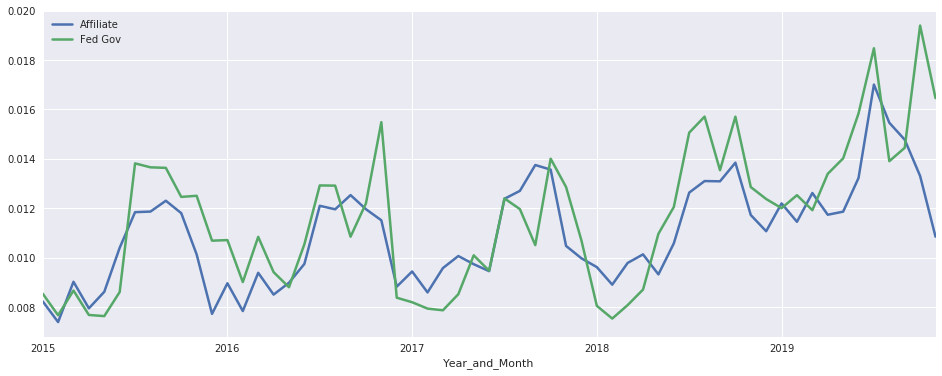

In [51]:
Channel.set_index('Year_and_Month')[['Affiliate','Fed Gov']].plot(figsize=(16, 6), linewidth=2.5)
plt.show()

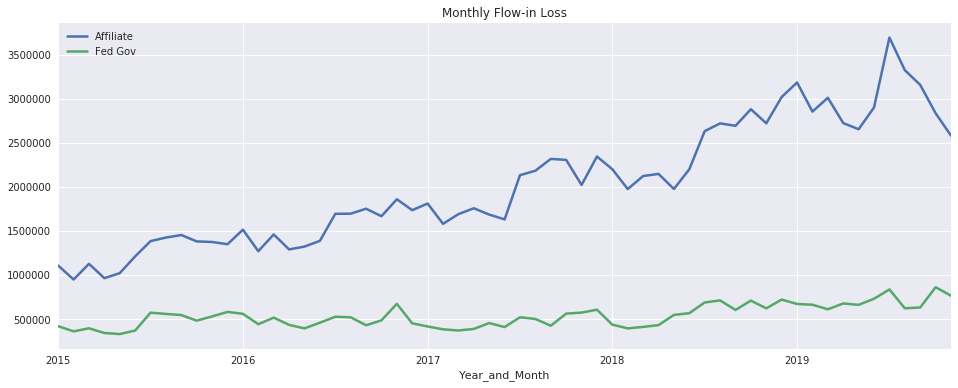

In [56]:
A.set_index('Year_and_Month')[['Affiliate','Fed Gov']].plot(title='Monthly Flow-in Loss',figsize=(16, 6), linewidth=2.5)
plt.show()

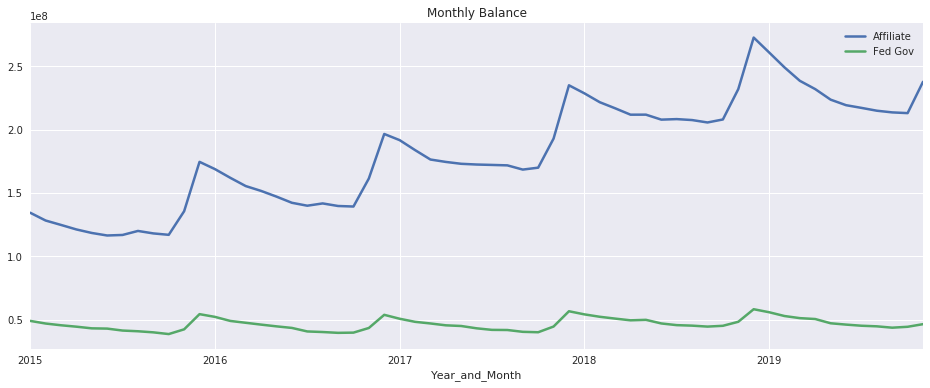

In [55]:
B.set_index('Year_and_Month')[['Affiliate','Fed Gov']].plot(title='Monthly Balance',figsize=(16, 6), linewidth=2.5)
plt.show()

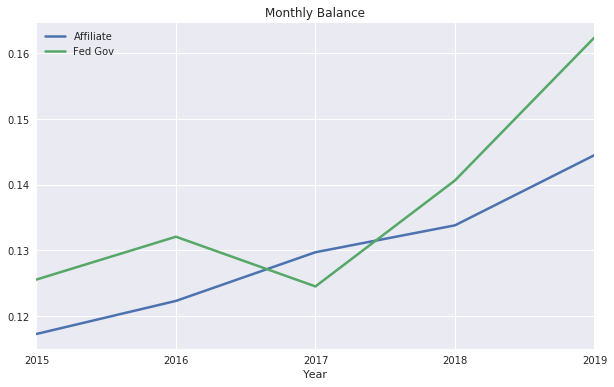

In [74]:
Channel.groupby(['Year']).agg({'Fed Gov':'sum','Affiliate':'sum'})[['Affiliate','Fed Gov']].plot(title='Monthly Balance',figsize=(10, 6), linewidth=2.5)
plt.show()

In [30]:
# Orders per Customer
Bad_Orders_p_cust = P15[(P15['Bad']==1)&(P15['Ever_Bad']==1)].groupby('Year').agg({'Unique_Customer_ID':'nunique','Unique_Order_ID':'nunique'}).reset_index()
Bad_Orders_p_cust['num_of_orders_per_cust'] = Bad_Orders_p_cust['Unique_Order_ID']/Bad_Orders_p_cust['Unique_Customer_ID']
Bad_Orders_p_cust['Year'] = pd.to_datetime(Bad_Orders_p_cust['Year'].astype(str),format='%Y')

In [35]:
Bad_Orders_p_cust

Year  Unique_Customer_ID  Unique_Order_ID  num_of_orders_per_cust
0 2015-01-01               19132            35978                1.880514
1 2016-01-01               22263            48784                2.191259
2 2017-01-01               26688            62995                2.360424
3 2018-01-01               31779            80360                2.528714
4 2019-01-01               33886            97880                2.888509

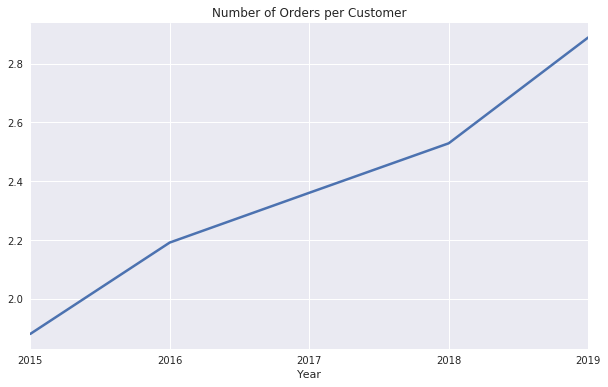

In [36]:
Bad_Orders_p_cust.set_index('Year')['num_of_orders_per_cust'].plot(title='Number of Orders per Customer',figsize=(10, 6), linewidth=2.5)
plt.show()

In [ ]:
P15[P15['Year_and_Month']=='2015-01-01'].groupby('Unique_Order_ID').filter(lambda x: x['Ever_Bad'].max()==0).shape[0] + P15[([P15['Year_and_Month']=='2015-01-01'])&(P15['Bad']==1)&(P15['Ever_Bad']==1)].shape[0]

In [15]:
P15[P15['Year_and_Month']=='2015-01-01'].shape[0]

316919

In [ ]:
# Unit Loss Rate

In [11]:
A_unit = P15[(P15['Bad']==1)&(P15['Ever_Bad']==1)].pivot_table(values = 'Unique_Order_ID',index = 'Year_and_Month', columns='Affiliate/Fed Gov?',aggfunc='nunique' ).reset_index().rename_axis(None, axis=1)

In [12]:
B_unit = P15.pivot_table(values = 'Unique_Order_ID',index = 'Year_and_Month', columns='Affiliate/Fed Gov?',aggfunc='nunique' ).reset_index().rename_axis(None, axis=1)

In [16]:
Channel_unit = A_unit.iloc[:,1:]/B_unit.iloc[:,1:]
Channel_unit['Year_and_Month'] = A_unit['Year_and_Month']
Channel_unit['Year'] = Channel_unit['Year_and_Month'].dt.year
Channel_unit['Year'] = pd.to_datetime(Channel_unit['Year'].astype(str),format='%Y')
Channel_unit

Affiliate   Fed Gov Year_and_Month       Year
0    0.009877  0.009729     2015-01-01 2015-01-01
1    0.008995  0.008705     2015-02-01 2015-01-01
2    0.009951  0.008546     2015-03-01 2015-01-01
3    0.008936  0.007634     2015-04-01 2015-01-01
4    0.008506  0.007313     2015-05-01 2015-01-01
5    0.008577  0.007024     2015-06-01 2015-01-01
6    0.009369  0.009625     2015-07-01 2015-01-01
7    0.009971  0.008941     2015-08-01 2015-01-01
8    0.010331  0.009414     2015-09-01 2015-01-01
9    0.009889  0.008851     2015-10-01 2015-01-01
10   0.009586  0.009647     2015-11-01 2015-01-01
11   0.008509  0.011050     2015-12-01 2015-01-01
12   0.009867  0.010623     2016-01-01 2016-01-01
13   0.008730  0.008824     2016-02-01 2016-01-01
14   0.009568  0.008319     2016-03-01 2016-01-01
15   0.008453  0.009057     2016-04-01 2016-01-01
16   0.007951  0.008427     2016-05-01 2016-01-01
17   0.007782  0.008114     2016-06-01 2016-01-01
18   0.009024  0.008496     2016-07-01 2016-01-01
19   0.009866  0.008989     2016-08-01 2016-01-01
20   0.010711  0.008111     2016-09-01 2016-01-01
21   0.010342  0.008546     2016-10-01 2016-01-01
22   0.010439  0.012209     2016-11-01 2016-01-01
23   0.009295  0.007342     2016-12-01 2016-01-01
24   0.011163  0.007503     2017-01-01 2017-01-01
25   0.010185  0.008363     2017-02-01 2017-01-01
26   0.010140  0.007195     2017-03-01 2017-01-01
27   0.010761  0.007087     2017-04-01 2017-01-01
28   0.009717  0.009236     2017-05-01 2017-01-01
29   0.007907  0.006177     2017-06-01 2017-01-01
30   0.009822  0.007389     2017-07-01 2017-01-01
31   0.010815  0.007713     2017-08-01 2017-01-01
32   0.011523  0.007855     2017-09-01 2017-01-01
33   0.012027  0.009925     2017-10-01 2017-01-01
34   0.009588  0.010320     2017-11-01 2017-01-01
35   0.010254  0.009601     2017-12-01 2017-01-01
36   0.010537  0.008219     2018-01-01 2018-01-01
37   0.009513  0.008265     2018-02-01 2018-01-01
38   0.010220  0.008271     2018-03-01 2018-01-01
39   0.009896  0.008574     2018-04-01 2018-01-01
40   0.008509  0.011451     2018-05-01 2018-01-01
41   0.008243  0.008188     2018-06-01 2018-01-01
42   0.009990  0.010470     2018-07-01 2018-01-01
43   0.010816  0.010270     2018-08-01 2018-01-01
44   0.011305  0.010564     2018-09-01 2018-01-01
45   0.012369  0.013623     2018-10-01 2018-01-01
46   0.010802  0.010608     2018-11-01 2018-01-01
47   0.011481  0.010880     2018-12-01 2018-01-01
48   0.012678  0.011671     2019-01-01 2019-01-01
49   0.011653  0.012574     2019-02-01 2019-01-01
50   0.012734  0.011321     2019-03-01 2019-01-01
51   0.012263  0.011680     2019-04-01 2019-01-01
52   0.011001  0.011771     2019-05-01 2019-01-01
53   0.011522  0.010906     2019-06-01 2019-01-01
54   0.013766  0.012773     2019-07-01 2019-01-01
55   0.013230  0.010805     2019-08-01 2019-01-01
56   0.013007  0.011401     2019-09-01 2019-01-01
57   0.011945  0.016328     2019-10-01 2019-01-01
58   0.010754  0.013292     2019-11-01 2019-01-01

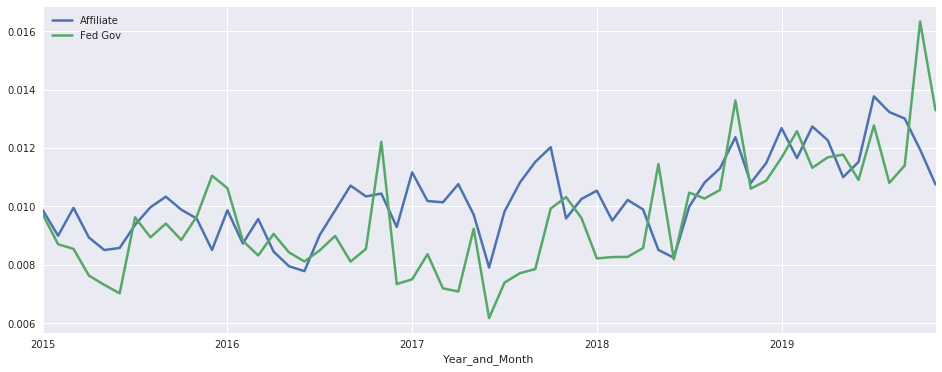

In [17]:
Channel_unit.set_index('Year_and_Month')[['Affiliate','Fed Gov']].plot(figsize=(16, 6), linewidth=2.5)
plt.show()

In [ ]:
Old_2015 = Perf[(Perf['Year_and_Month']>='2014-12-01') & (Perf['Year_and_Month']<='2015-11-01')]
New_2019 = Perf[(Perf['Year_and_Month']>='2018-12-01') & (Perf['Year_and_Month']<='2019-11-01')]

In [44]:
Old_2015['Flag'] = 'Old'
New_2019['Flag'] = 'New'
df = Old_2015.append(New_2019,ignore_index = True)

In [41]:
# Loss rate by Channel
Old_lr = Old_2015[(Old_2015['Bad']==1) & (Old_2015['Ever_Bad']==1)]['2os_loss'].sum()/Old_2015['Current_Balance'].sum()*12
New_lr = New_2019[(New_2019['Bad']==1) & (New_2019['Ever_Bad']==1)]['2os_loss'].sum()/New_2019['Current_Balance'].sum()*12
print('2015 Loss Rate {}'.format(Old_lr))
print('2019 Loss Rate {}'.format(New_lr))

2015 Loss Rate 0.11300565278586913
2019 Loss Rate 0.15729958806109115


In [54]:
df[(df['Bad']==1)&(df['Ever_Bad']==1)].pivot_table(values = '2os_loss',index = 'Affiliate/Fed Gov?',columns='Flag',aggfunc='sum').rename_axis(None,axis=1).reset_index()

Affiliate/Fed Gov?          New          Old
0          Affiliate  35934490.75  14633864.49
1            Fed Gov   8448989.94   5418059.08

In [52]:
df.pivot_table(values = 'Current_Balance',index = 'Affiliate/Fed Gov?',columns='Flag',aggfunc='sum').rename_axis(None,axis=1).reset_index()

Affiliate/Fed Gov?           New           Old
0          Affiliate  2.793072e+09  1.490401e+09
1            Fed Gov  5.866059e+08  5.271890e+08

In [43]:
# Old_2015[(Old_2015['Bad']==1) & (Old_2015['Ever_Bad']==1)].groupby('Affiliate/Fed Gov?').agg({'2os_loss':'sum'})

2os_loss
Affiliate/Fed Gov?             
Affiliate           14633864.49
Fed Gov              5418059.08

In [63]:
# Loss rate by Industry
loss_Ind = df[(df['Bad']==1)&(df['Ever_Bad']==1)].pivot_table(values = '2os_loss',index = 'Industry',columns='Flag',aggfunc='sum').rename_axis(None,axis=1).reset_index()#.fillna(0)
# loss_Ind.rename(columns={'New'})

prefix = 'loss_'
new_names = [(i,prefix + i) for i in ['New','Old']]
loss_Ind.rename(columns = dict(new_names), inplace=True)
loss_Ind

Industry     loss_New    loss_Old
0                    Accommodation and Food Services   1884986.18   252588.87
1                         Administrative and Support    688263.07   229397.90
2                Arts, Entertainment, and Recreation     14519.90         NaN
3                                       Construction      7836.01         NaN
4                               Educational Services    456467.73   215692.45
5                    Federal Government/Associations   8448989.94  5418059.08
6                              Finance and Insurance   1140680.29   628858.93
7                  Health Care and Social Assistance  11059271.43  4158014.42
8                                        Information   3563246.22  1378838.90
9                      Local Government/Associations    797014.24   181906.19
10           Management of Companies and Enterprises    107879.50     5290.65
11                                     Manufacturing   3855554.89  1307021.45
12     Mining, Quarrying, and Oil and Gas Extraction      1248.49    92208.18
13           Nursing and Residential Care Facilities   1167625.56   954277.06
14     Other Services (except Public Administration)    621860.44   295328.16
15  Professional, Scientific, and Technical Services    637300.06   181054.13
16                Real Estate and Rental and Leasing     20596.79    20702.91
17                                      Retail Trade   4843285.95  2528694.17
18                     State Government/Associations   3182177.73  1626108.34
19                    Transportation and Warehousing   1074870.16   511707.08
20                                         Utilities      5130.20     7478.10
21                                   Wholesale Trade    810878.06    97673.79

In [62]:
bal_Ind = df.pivot_table(values = 'Current_Balance',index = 'Industry',columns='Flag',aggfunc='sum').rename_axis(None,axis=1).reset_index()#.fillna(0)

prefix = 'Balance_'
new_names = [(i,prefix + i) for i in ['New','Old']]
bal_Ind.rename(columns = dict(new_names), inplace=True)
bal_Ind

Industry   Balance_New   Balance_Old
0                    Accommodation and Food Services  1.275671e+08  1.720143e+07
1                         Administrative and Support  4.208072e+07  1.641455e+07
2                Arts, Entertainment, and Recreation  2.764343e+05           NaN
3                                       Construction  5.435360e+05           NaN
4                               Educational Services  6.650985e+07  1.929554e+07
5                                        Engineering  5.713768e+04  1.825912e+04
6                    Federal Government/Associations  5.866059e+08  5.271890e+08
7                              Finance and Insurance  9.397760e+07  5.502826e+07
8                  Health Care and Social Assistance  9.377450e+08  4.286868e+08
9                                         Healthcare  5.554429e+05           NaN
10                                       Information  1.702490e+08  1.386046e+08
11                     Local Government/Associations  8.858890e+07  2.898198e+07
12                                         Machinery  3.827341e+04           NaN
13           Management of Companies and Enterprises  7.671229e+06  2.493562e+05
14                                     Manufacturing  2.698433e+08  1.220994e+08
15     Mining, Quarrying, and Oil and Gas Extraction  7.762625e+05  4.412838e+06
16           Nursing and Residential Care Facilities  8.505518e+07  7.413543e+07
17     Other Services (except Public Administration)  4.471422e+07  5.387714e+07
18  Professional, Scientific, and Technical Services  4.021132e+07  1.213512e+07
19                Real Estate and Rental and Leasing  1.087191e+06  1.654978e+06
20                                            Retail  7.325184e+04           NaN
21                          Retail & Wholesale Trade  1.103328e+05           NaN
22                                      Retail Trade  3.549607e+08  2.268014e+08
23                     State Government/Associations  3.111288e+08  2.321441e+08
24                    Transportation and Warehousing  1.045316e+08  7.118683e+07
25                                         Utilities  1.049598e+06  7.276528e+05
26                                   Wholesale Trade  4.653468e+07  9.005215e+06

In [64]:
Ind = bal_Ind.merge(loss_Ind, how='left',on='Industry')#.fillna(0)
Ind

Industry   Balance_New   Balance_Old     loss_New    loss_Old
0                    Accommodation and Food Services  1.275671e+08  1.720143e+07   1884986.18   252588.87
1                         Administrative and Support  4.208072e+07  1.641455e+07    688263.07   229397.90
2                Arts, Entertainment, and Recreation  2.764343e+05           NaN     14519.90         NaN
3                                       Construction  5.435360e+05           NaN      7836.01         NaN
4                               Educational Services  6.650985e+07  1.929554e+07    456467.73   215692.45
5                                        Engineering  5.713768e+04  1.825912e+04          NaN         NaN
6                    Federal Government/Associations  5.866059e+08  5.271890e+08   8448989.94  5418059.08
7                              Finance and Insurance  9.397760e+07  5.502826e+07   1140680.29   628858.93
8                  Health Care and Social Assistance  9.377450e+08  4.286868e+08  11059271.43  4158014.42
9                                         Healthcare  5.554429e+05           NaN          NaN         NaN
10                                       Information  1.702490e+08  1.386046e+08   3563246.22  1378838.90
11                     Local Government/Associations  8.858890e+07  2.898198e+07    797014.24   181906.19
12                                         Machinery  3.827341e+04           NaN          NaN         NaN
13           Management of Companies and Enterprises  7.671229e+06  2.493562e+05    107879.50     5290.65
14                                     Manufacturing  2.698433e+08  1.220994e+08   3855554.89  1307021.45
15     Mining, Quarrying, and Oil and Gas Extraction  7.762625e+05  4.412838e+06      1248.49    92208.18
16           Nursing and Residential Care Facilities  8.505518e+07  7.413543e+07   1167625.56   954277.06
17     Other Services (except Public Administration)  4.471422e+07  5.387714e+07    621860.44   295328.16
18  Professional, Scientific, and Technical Services  4.021132e+07  1.213512e+07    637300.06   181054.13
19                Real Estate and Rental and Leasing  1.087191e+06  1.654978e+06     20596.79    20702.91
20                                            Retail  7.325184e+04           NaN          NaN         NaN
21                          Retail & Wholesale Trade  1.103328e+05           NaN          NaN         NaN
22                                      Retail Trade  3.549607e+08  2.268014e+08   4843285.95  2528694.17
23                     State Government/Associations  3.111288e+08  2.321441e+08   3182177.73  1626108.34
24                    Transportation and Warehousing  1.045316e+08  7.118683e+07   1074870.16   511707.08
25                                         Utilities  1.049598e+06  7.276528e+05      5130.20     7478.10
26                                   Wholesale Trade  4.653468e+07  9.005215e+06    810878.06    97673.79

In [66]:
# Loss rate by Client
loss_Cli = df[(df['Bad']==1)&(df['Ever_Bad']==1)].pivot_table(values = '2os_loss',index = 'Account Name',columns='Flag',aggfunc='sum').rename_axis(None,axis=1).reset_index().fillna(0)
prefix = 'loss_'
new_names = [(i,prefix + i) for i in ['New','Old']]
loss_Cli.rename(columns = dict(new_names), inplace=True)

bal_Cli = df.pivot_table(values = 'Current_Balance',index = 'Account Name',columns='Flag',aggfunc='sum').rename_axis(None,axis=1).reset_index()
prefix = 'Balance_'
new_names = [(i,prefix + i) for i in ['New','Old']]
bal_Cli.rename(columns = dict(new_names), inplace=True)


In [68]:
Cli = bal_Cli.merge(loss_Cli, how='left',on='Account Name').fillna(0)
Cli.to_csv('../data/Cli.csv',index = False)
Cli

Account Name   Balance_New   Balance_Old    loss_New    loss_Old
0                             7-ELEVEN INC. (Inactive)  0.000000e+00  6.458470e+05        0.00     9800.42
1                                       7-ELEVEN, INC.  1.253553e+05  5.667191e+05     3678.88     7756.68
2                                      ABINGTON HEALTH  2.997950e+03  8.668794e+05        0.00    21466.79
3                                      ACTIVE MILITARY  1.338980e+04  8.926253e+05     1179.17    43021.12
4                    ADELANTE DEVELOPMENT CENTER, INC.  0.000000e+00  5.589800e+03        0.00        0.00
5                                     ADP TOTAL SOURCE  0.000000e+00  3.771805e+06        0.00   220197.45
6                                         ADTRAN, INC.  3.107609e+05  0.000000e+00        0.00        0.00
7                             ADVANCE AUTO PARTS, INC.  3.449564e+07  2.104372e+07   598821.72   259507.97
8                                                AECOM  8.146848e+06  4.089357e+06   121018.58    64085.14
9                                                 AFNI  1.318722e+06  1.543764e+06    23605.09    32417.95
10                         AIR FORCE ASSOCIATION (AFA)  0.000000e+00  5.944068e+04        0.00      853.48
11                 ALABAMA STATE EMPLOYEES ASSOCIATION  6.616936e+06  6.495919e+06    54252.45    46035.00
12                                         ALERE, INC.  7.913080e+03  1.232754e+06      792.35    29955.91
13                                 ALLIANCE HEALTHCARE  6.424950e+03  9.210949e+05        0.00     3080.38
14                        ALLIANCE RESIDENTIAL COMPANY  1.096120e+03  1.076040e+06      140.75    15673.07
15                          ALLINA HOSPITALS & CLINICS  8.433181e+06  7.210633e+06   114680.40    59443.93
16                                    ALPHASTAFF, INC.  1.849675e+06  1.238750e+06    52454.26    20796.22
17         AMERICAN FEDERATION OF GOVERNMENT EMPLOYEES  5.950113e+07  7.073871e+07   581497.87   590660.49
18                                  AMERICAN RED CROSS  1.962418e+07  1.603416e+07   224478.18   176283.20
19        ANHEUSER BUSCH - AMERICAN EAGLE CREDIT UNION  0.000000e+00  4.078625e+05        0.00     7289.91
20                                         APL LIMITED  0.000000e+00  1.422276e+05        0.00    12391.27
21                                       APL LOGISTICS  1.160584e+06  5.835048e+05    19459.65     1476.64
22              APPALACHIAN REGIONAL HEALTHCARE SYSTEM  1.183425e+06  7.077605e+05     2518.55     1162.66
23                                                APWU  4.867652e+06  6.428200e+03    12402.78        0.00
24                                             ARCHWAY  0.000000e+00  5.920965e+05        0.00     5271.69
25                ARKANSAS STATE EMPLOYEES ASSOCIATION  1.054326e+04  5.858608e+06        0.00   166963.00
26          ARKANSAS STATE EMPLOYEES ASSOCIATION (ACH)  3.289403e+06  1.304793e+07    64202.90     3375.77
27                             ARTHUR J GALLAGHER & CO  4.537948e+06  3.698505e+06    51963.75    29630.46
28                                        ASPEN DENTAL  3.348319e+06  1.452144e+06    53009.79    12300.70
29                  ASSOCIATED WHOLESALE GROCERS, INC.  2.525998e+06  0.000000e+00    36288.33        0.00
30                                  ATHENA HEALTH CARE  5.955271e+05  0.000000e+00     1984.66        0.00
31                           ATLANTIC GENERAL HOSPITAL  3.325503e+05  4.435170e+05     3931.32     5527.94
32                       AUGEO AFFINITY MARKETING, INC  1.488414e+04  4.765178e+04     1123.23      540.92
33                  AUSTIN TRAVIS COUNTY INTEGRAL CARE  0.000000e+00  8.079800e+02        0.00       86.86
34                                         AUTOLIV ASP  2.484644e+06  0.000000e+00    22237.08        0.00
35                              AUTOPART INTERNATIONAL  3.100203e+05  3.654163e+05     4666.79     5507.03
36                                               AVERA  4.537100e+02  8.770625e+05 

In [ ]:
def risk_analysis(df, values_level, index_list, file_name):
    """
    values_level := ['Unique_Order_ID','Unique_Customer_ID','2os_loss']

    """

    if values_level == 'Unique_Order_ID':
        dfs = df.pivot_table(values='Unique_Order_ID', index=index_list,
                             columns='YQ', aggfunc='nunique').reset_index().rename_axis(None, axis=1)
#         new_names = [(i,i+'_unit') for i in df.iloc[:, 2:].columns.values]
#         dfs.rename(columns = dict(new_names), inplace=True)
    elif values_level == 'Unique_Customer_ID':
        dfs = df.pivot_table(values='Unique_Customer_ID', index=index_list,
                             columns='YQ', aggfunc='nunique').reset_index().rename_axis(None, axis=1)
#         new_names = [(i,i+'_customer') for i in df.iloc[:, 2:].columns.values]
#         dfs.rename(columns = dict(new_names), inplace=True)
    elif values_level == '2os_loss':
        dfs = df[df['Bad']==1]
        dfs = dfs.loc[dfs.groupby('Unique_Order_ID')['Year_and_Month'].idxmin()].pivot_table(values='2os_loss', index=index_list, columns='YQ',
                             aggfunc='sum').reset_index().rename_axis(None, axis=1)
#         new_names = [(i,str(i)+'_loss') for i in df.iloc[:, 2:].columns.values]
#         dfs.rename(columns = dict(new_names), inplace=True)
    elif values_level == 'all':
        unit = df.pivot_table(values='Unique_Order_ID', index=index_list,
                             columns='YQ', aggfunc='nunique').reset_index().rename_axis(None, axis=1)
        new_names = [(i,str(i)+'_unit') for i in unit.iloc[:, 2:].columns.values]
        unit.rename(columns = dict(new_names), inplace=True)
        
        cust = df.pivot_table(values='Unique_Customer_ID', index=index_list,
                             columns='YQ', aggfunc='nunique').reset_index().rename_axis(None, axis=1)
        new_names = [(i,str(i)+'_customer') for i in cust.iloc[:, 2:].columns.values]
        cust.rename(columns = dict(new_names), inplace=True)
        
        loss = df.pivot_table(values='2os_loss', index=index_list, columns='YQ',
                             aggfunc='sum').reset_index().rename_axis(None, axis=1)
        new_names = [(i,str(i)+'_loss') for i in loss.iloc[:, 2:].columns.values]
        loss.rename(columns = dict(new_names), inplace=True)
        
        dfs = reduce(lambda x,y: pd.merge(x,y, how='left',on=index_list),[unit,cust,loss])
        
    else:
        print('Not valid values_level')
    dfs.to_csv('../data/{}.csv'.format(file_name))
    return dfs